In [76]:
# Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import optuna

In [77]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
# Counting the number of images in train and test datasets
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [79]:
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")

# Images Train: 50000
# Images Test:  10000


In [80]:
# Displaying the shape of a sample image and its label
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


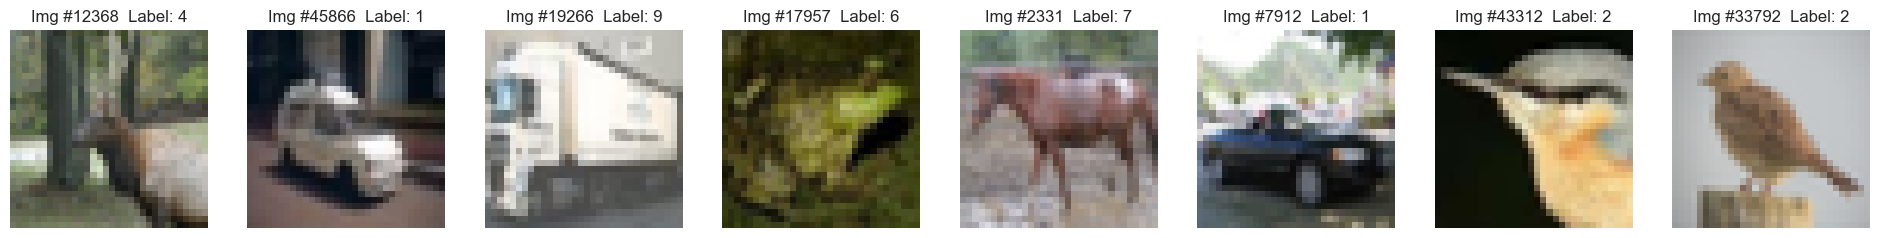

In [81]:
# Displaying a few random images from the training dataset


N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().transpose(1, 2, 0)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [82]:
BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

In [83]:
train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [84]:
# Checking the shape of a sample batch
imgs, labels = next(iter(eval_loader))
print(f"{imgs.shape = }")
print(f"{labels.shape = }")

imgs.shape = torch.Size([1024, 3, 32, 32])
labels.shape = torch.Size([1024])


In [85]:
for i, (imgs, labels) in enumerate(eval_loader):
    print(f"Iterating batch #{i+1}, which has {len(labels)} elements")
    if i > 10:
        break

Iterating batch #1, which has 1024 elements
Iterating batch #2, which has 1024 elements
Iterating batch #3, which has 1024 elements
Iterating batch #4, which has 1024 elements
Iterating batch #5, which has 1024 elements
Iterating batch #6, which has 1024 elements
Iterating batch #7, which has 1024 elements
Iterating batch #8, which has 1024 elements
Iterating batch #9, which has 1024 elements
Iterating batch #10, which has 784 elements


In [86]:
import torch.nn as nn

In [87]:
# Import the necessary PyTorch library for neural networks
import torch.nn as nn

# Defining a simple multi-layer perceptron (MLP) model
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to the number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim, hidden_dims=[128], output_dim=10):
        super().__init__()  # Initialize the parent class (nn.Module)
        layers = []  # Create an empty list to store layers
        prev_dim = input_dim  # Initialize the previous dimension to the input dimension
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))  # Add a fully connected layer to the list
            layers.append(nn.ReLU())  # Add a ReLU activation function to the list
            prev_dim = h_dim  # Update the previous dimension for the next layer
        layers.append(nn.Linear(prev_dim, output_dim))  # Add the output layer to the list
        self.layers = nn.Sequential(*layers)  # Create a sequential container for the layers
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"  # Check input shape
        pred = self.layers(x)  # Pass input through the defined layers
        return pred

# Helper function to count the number of learnable parameters in the model
def count_model_params(model):
    """ Counting the number of learnable parameters in an nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # Count parameters with gradients
    return num_params

In [88]:
# Initializing the model and displaying its structure
model = Model(input_dim=3*32*32, hidden_dims=[128, 64], output_dim=10)
print(model)

Model(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [89]:
count_model_params(model)

402250

In [90]:
train_loss_list = []
eval_loss_list = []
train_accuracy_list = []
eval_accuracy_list = []

In [91]:
# Demonstrating a forward pass using a sample batch
imgs, labels = next(iter(eval_loader))      # sampling images
flattened_imgs = imgs.view(imgs.size(0), -1)  # reshaping to desired size
output = model(flattened_imgs)              # forward pass through model

print(f"Imgs shape:         {imgs.shape}")
print(f"Model input shape:  {flattened_imgs.shape}")
print(f"Model output shape: {output.shape}")

Imgs shape:         torch.Size([1024, 3, 32, 32])
Model input shape:  torch.Size([1024, 3072])
Model output shape: torch.Size([1024, 10])


In [92]:
from tqdm import tqdm

In [93]:
NUM_EPOCHS = 3
# Somewhere before training loop
grad_stats = {
    'grad_norm': [],
    'grad_max': [],
    'grad_mean': []
}

In [94]:
loss_list = []  # Initialize an empty list to store training losses

# Objective function for hyperparameter optimization
def objective(trial):
    # Suggesting hyperparameters using optuna
    num_layers = trial.suggest_int('num_layers', 1, 3)  # Suggest the number of hidden layers
    hidden_dims = [trial.suggest_int(f'hidden_dim_{i}', 32, 256) for i in range(num_layers)]  # Suggest hidden layer dimensions

    # Initializing model, optimizer, and loss for the suggested hyperparameters
    model = Model(input_dim=3*32*32, hidden_dims=hidden_dims).to(device)  # Create a model with the suggested architecture
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)  # Use Adam optimizer with suggested learning rate
    criterion = nn.CrossEntropyLoss()  # Define the loss function for classification tasks

    # Training loop for the current set of hyperparameters
    for epoch in range(NUM_EPOCHS):
        progress_bar = tqdm(train_loader, total=len(train_loader))
        total_train_loss = 0
        correct_train_preds = 0
        total_train_samples = 0
        savepath = f"models/checkpoint_epoch_{epoch}.pth"  # Define a path to save model checkpoints
        
        for i, (imgs, labels) in enumerate(progress_bar):
            # Using GPU
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Forward pass
            flattened_imgs = imgs.view(imgs.size(0), -1)  # Flatten input images
            preds = model(flattened_imgs)  # Pass images through the model
            
            # Computing error
            loss = criterion(preds, labels)  # Calculate the cross-entropy loss
            total_train_loss += loss.item() * imgs.size(0)  # Accumulate the total training loss
            correct_train_preds += (preds.argmax(1) == labels).sum().item()  # Count correct predictions
            total_train_samples += imgs.size(0)  # Count total training samples
            loss_list.append(loss.item())  # Append the current loss to the list
            
            # Removing accumulated gradients
            optimizer.zero_grad()
            
            # Backpropagating error to compute gradients
            loss.backward()
            
            # Updating parameters
            optimizer.step()
    
            if(i % 10 == 0 or i == len(train_loader) - 1):
                progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

            # Visualize Gradient Statistics
            for name, param in model.named_parameters():
                if "bias" not in name:  # Usually, we don't visualize biases
                    grad_stats['grad_norm'].append(param.grad.norm().item())
                    grad_stats['grad_max'].append(param.grad.max().item())
                    grad_stats['grad_mean'].append(param.grad.mean().item())

        # After each epoch, save the training loss and accuracy:
        train_loss_list.append(total_train_loss / total_train_samples)
        train_accuracy_list.append(100. * correct_train_preds / total_train_samples)
        
    
        # Evaluate on the test set after each epoch:
        # Evaluating the model on the validation set
        model.eval()
        total_eval_loss = 0
        correct_eval_preds = 0
        total_eval_samples = 0
        accuracy = 0
        with torch.no_grad():
            for imgs, labels in eval_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                flattened_imgs = imgs.view(imgs.size(0), -1)
                preds = model(flattened_imgs)
                accuracy += (preds.argmax(1) == labels).sum().item()

                loss = criterion(preds, labels)
                total_eval_loss += loss.item() * imgs.size(0)
                correct_eval_preds += (preds.argmax(1) == labels).sum().item()
                total_eval_samples += imgs.size(0)

        # After each epoch, save the eval loss and accuracy:
        eval_loss_list.append(total_eval_loss / total_eval_samples)
        eval_accuracy_list.append(100. * correct_eval_preds / total_eval_samples)
        accuracy /= len(test_dataset)
        return accuracy  # Return the accuracy as the objective to optimize


In [95]:
# Setting hyperparameters for the optimization process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=3*32*32, hidden_dims=[128, 64], output_dim=10)
model = model.to(device)

In [96]:
# Create an Optuna study for hyperparameter optimization, specifying to maximize the objective function
study = optuna.create_study(direction='maximize')

# Run the optimization process using the defined objective function for a specified number of trials (30 in this case)
study.optimize(objective, n_trials=30)

# Print the results of the hyperparameter optimization
print('Number of finished trials: ', len(study.trials))  # Print the number of completed trials
print('Best trial:')  # Print information about the best trial found

# Retrieve and print the best trial's value (accuracy)
trial = study.best_trial
print('Value: ', trial.value)

# Print the hyperparameters of the best trial
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-10-29 14:42:27,550] A new study created in memory with name: no-name-85f4d659-b91e-4cf9-b8cf-5e2207fd3e83
Epoch 1 Iter 49: loss 1.87999. : 100%|██████████| 49/49 [00:06<00:00,  7.11it/s]
[I 2023-10-29 14:42:35,683] Trial 0 finished with value: 0.3265 and parameters: {'num_layers': 1, 'hidden_dim_0': 164}. Best is trial 0 with value: 0.3265.
Epoch 1 Iter 49: loss 2.01948. : 100%|██████████| 49/49 [00:06<00:00,  7.27it/s]
[I 2023-10-29 14:42:43,656] Trial 1 finished with value: 0.2662 and parameters: {'num_layers': 3, 'hidden_dim_0': 103, 'hidden_dim_1': 82, 'hidden_dim_2': 97}. Best is trial 0 with value: 0.3265.
Epoch 1 Iter 49: loss 1.95256. : 100%|██████████| 49/49 [00:07<00:00,  6.89it/s]
[I 2023-10-29 14:42:52,044] Trial 2 finished with value: 0.3272 and parameters: {'num_layers': 1, 'hidden_dim_0': 213}. Best is trial 2 with value: 0.3272.
Epoch 1 Iter 49: loss 2.01716. : 100%|██████████| 49/49 [00:06<00:00,  7.68it/s]
[I 2023-10-29 14:42:59,634] Trial 3 finished with valu

Number of finished trials:  30
Best trial:
Value:  0.3471
Params: 
    num_layers: 1
    hidden_dim_0: 243


In [97]:
def smooth(f, K=31):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    if K % 2 == 0:  # Ensure K is always odd by incrementing it if necessary
        K += 1
    kernel = np.ones(K) / K  # Create a kernel with ones, representing a simple mean filter
    print("Value of K:", K)  # Print the value of K (filter size)
    print("Kernel:", kernel)  # Print the kernel used for smoothing
    
    # Extend the input function 'f' to account for boundaries by wrapping it around
    f = np.concatenate([f[int(K//2):], f, f[:int(K//2)]])
    
    # Apply convolution to smooth the extended function using the kernel
    smooth_f = np.convolve(f, kernel, mode="same")
    
    # Remove the boundary artifacts introduced earlier
    smooth_f = smooth_f[int(K//2): -int(K//2)]
    
    return smooth_f  # Return the smoothed function

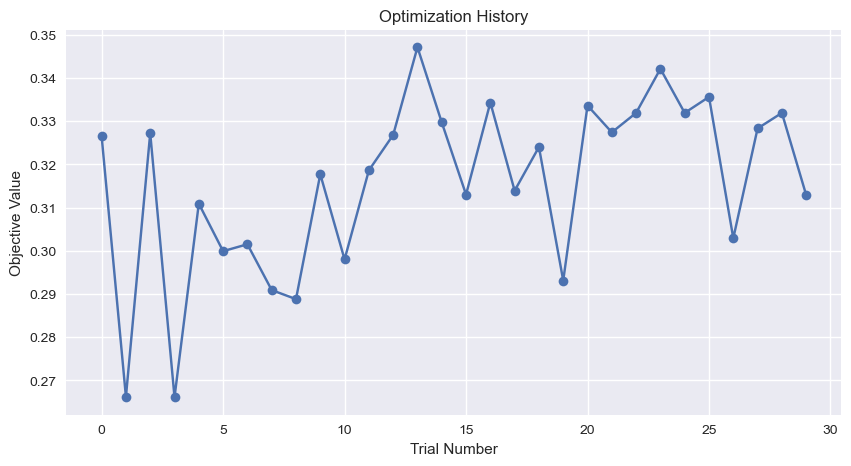

In [98]:

import matplotlib.pyplot as plt

def plot_optimization_history(study):
    # Convert the study's trials into a DataFrame
    trial_df = study.trials_dataframe()
    
    # Create a new figure with specified size
    plt.figure(figsize=(10, 5))
    
    # Plot the trial numbers against their objective values
    plt.plot(trial_df['number'], trial_df['value'], marker='o')
    
    # Set the title for the graph
    plt.title('Optimization History')
    
    # Label the x-axis as 'Trial Number'
    plt.xlabel('Trial Number')
    
    # Label the y-axis as 'Objective Value'
    plt.ylabel('Objective Value')
    
    # Enable grid for better readability of the graph
    plt.grid(True)
    
    # Display the graph
    plt.show()

# Call the function to plot the optimization history of a given study
plot_optimization_history(study)




Statistics for params_hidden_dim_0:
Minimum: 36
Maximum: 255
Average: 184.67
Best value (for min objective): 36

Statistics for params_hidden_dim_1:
Minimum: 53.0
Maximum: 247.0
Average: 146.27
Best value (for min objective): 111.0

Statistics for params_hidden_dim_2:
Minimum: 97.0
Maximum: 227.0
Average: 153.00
Best value (for min objective): nan

Statistics for params_num_layers:
Minimum: 1
Maximum: 3
Average: 1.50
Best value (for min objective): 2


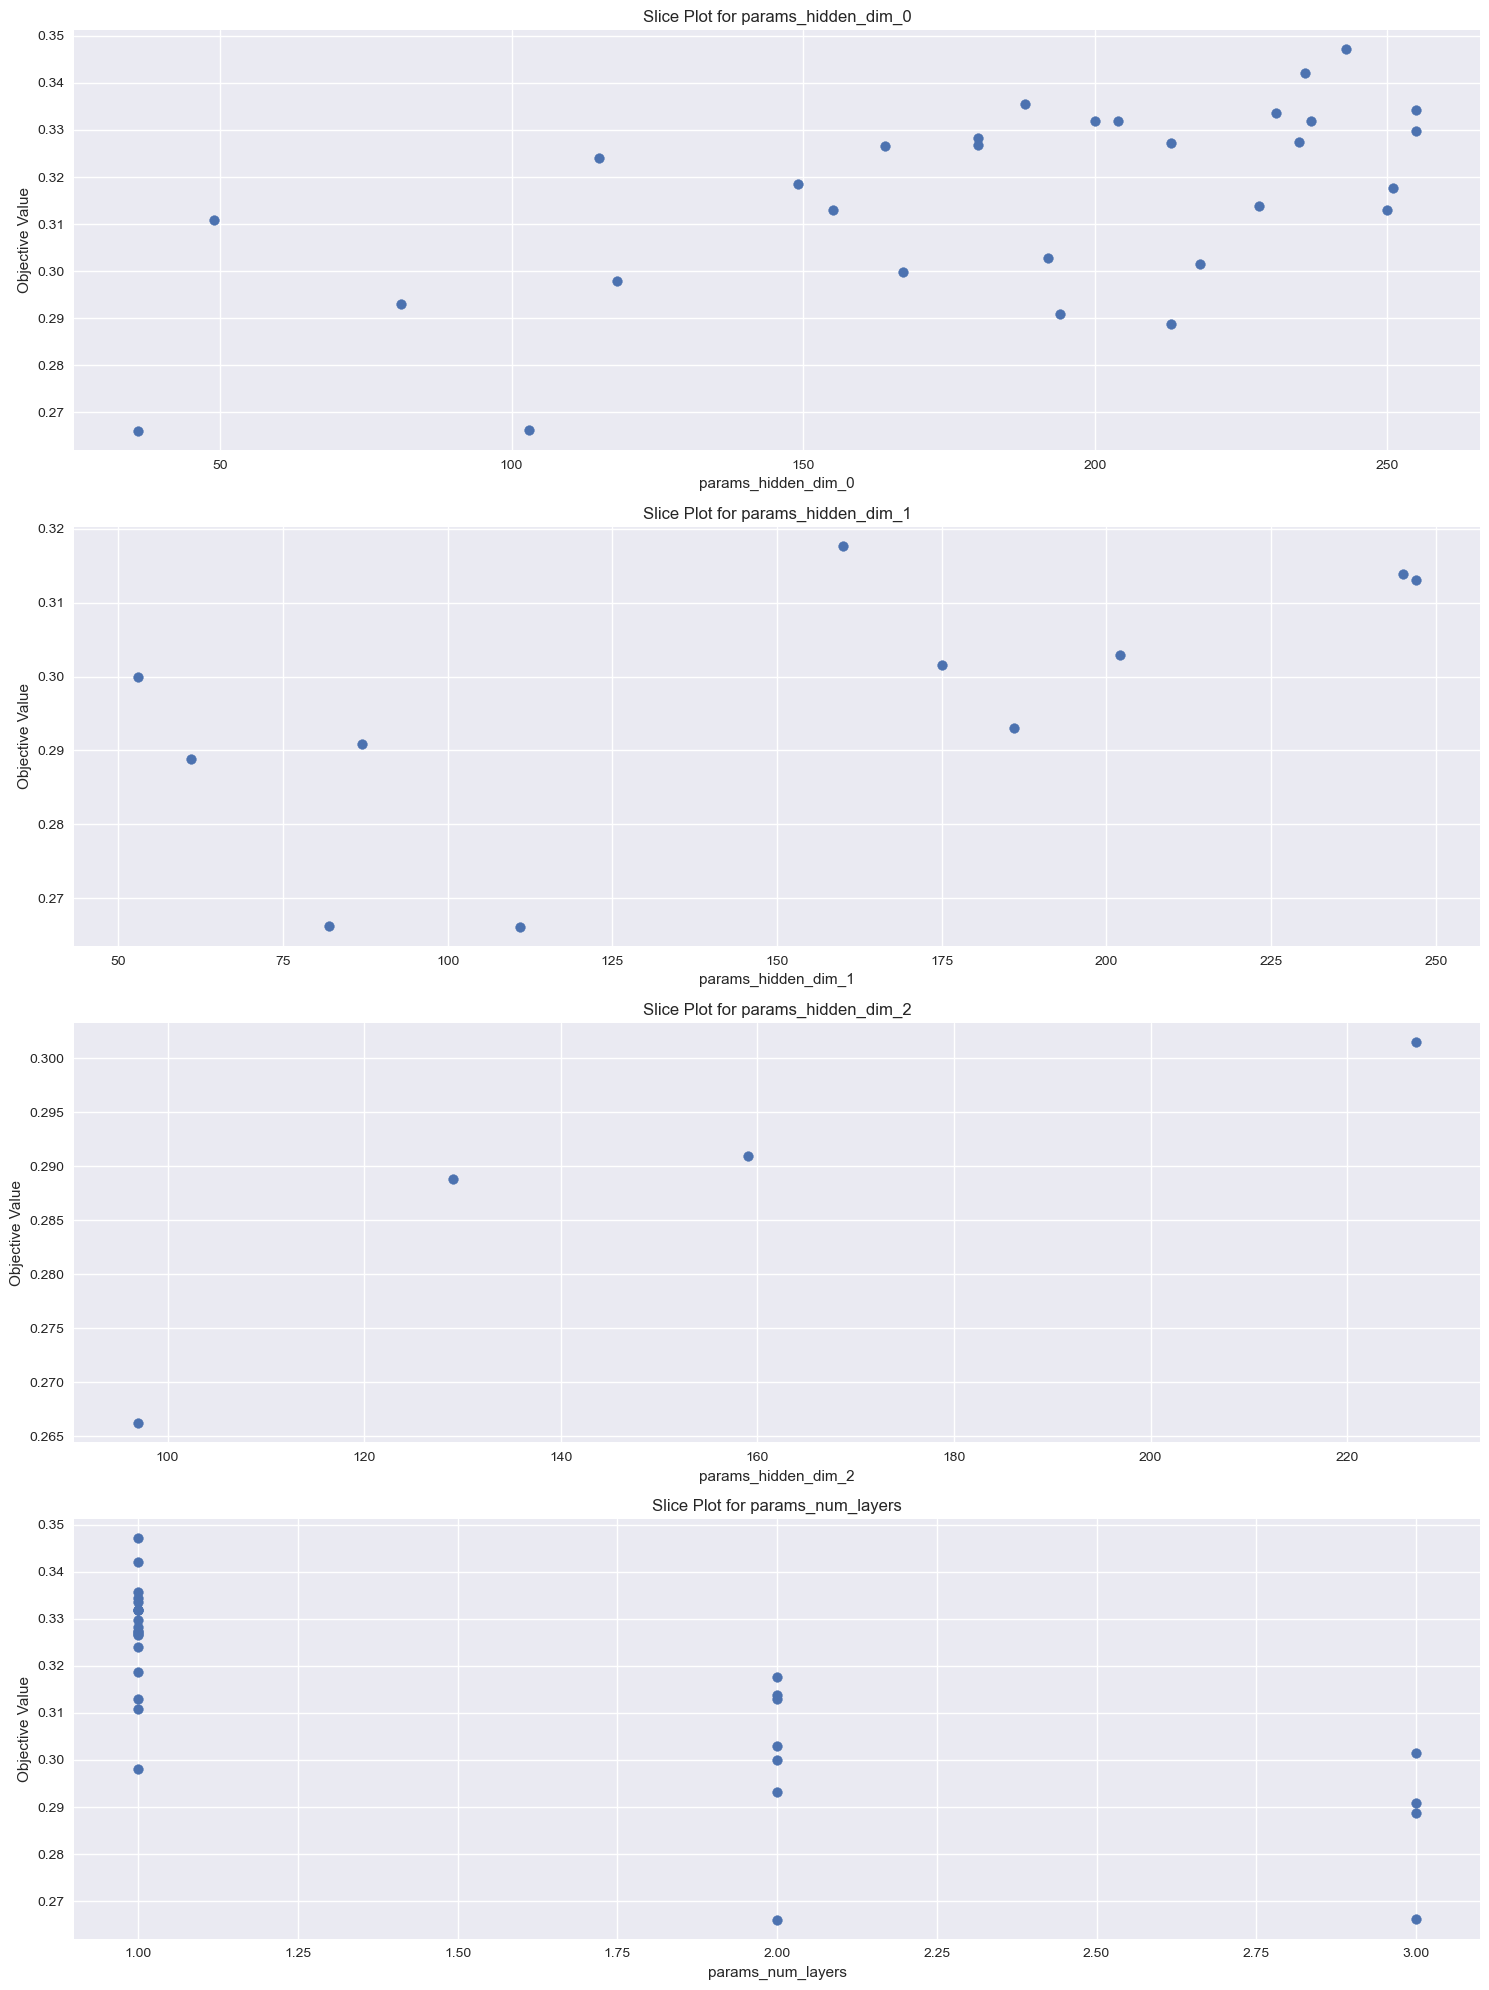

In [99]:
def plot_slice(study):
    trial_df = study.trials_dataframe()
    params = [col for col in trial_df.columns if col.startswith('params_')]
    
    # To store important statistics
    stats = {}
    
    plt.figure(figsize=(15, 5 * len(params)))
    for idx, param in enumerate(params, 1):
        plt.subplot(len(params), 1, idx)
        plt.scatter(trial_df[param], trial_df['value'], marker='o')
        plt.title(f'Slice Plot for {param}')
        plt.xlabel(param)
        plt.ylabel('Objective Value')
        plt.grid(True)

        # Extract and print key statistics for each parameter
        min_val = trial_df[param].min()
        max_val = trial_df[param].max()
        mean_val = trial_df[param].mean()
        best_val = trial_df[trial_df['value'] == trial_df['value'].min()][param].values[0]

        stats[param] = {
            'Min': min_val,
            'Max': max_val,
            'Mean': mean_val,
            'Best value (for min objective)': best_val
        }

        print(f"\nStatistics for {param}:")
        print(f"Minimum: {min_val}")
        print(f"Maximum: {max_val}")
        print(f"Average: {mean_val:.2f}")
        print(f"Best value (for min objective): {best_val}")

    plt.tight_layout()
    plt.show()
    
    return stats

stats = plot_slice(study)

Value of K: 5
Kernel: [0.2 0.2 0.2 0.2 0.2]


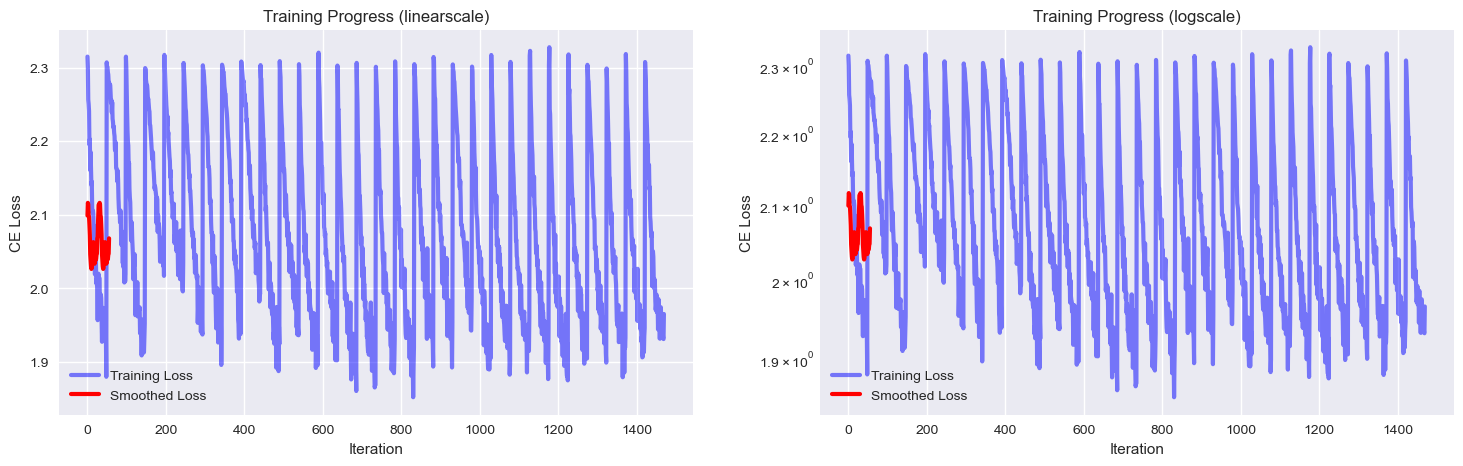

Training Loss Statistics:
 - Minimum: 1.8522
 - Maximum: 2.3279
 - Average: 2.0634
 - Final value: 1.9653

Smoothed Loss Statistics:
 - Minimum: 2.0266
 - Maximum: 2.1164
 - Average: 2.0616
 - Final value: 2.0682


In [100]:
import seaborn as sns
import numpy as np  # for statistical measures

sns.set_style("darkgrid")

fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

smooth_loss = smooth(train_loss_list, K=5)

# Plotting as in your original snippet
ax[0].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Progress (linearscale)")

ax[1].plot(loss_list, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_yscale("log")
ax[1].set_title("Training Progress (logscale)")

plt.show()

# Extracting and printing important information
print("Training Loss Statistics:")
print(f" - Minimum: {np.min(loss_list):.4f}")
print(f" - Maximum: {np.max(loss_list):.4f}")
print(f" - Average: {np.mean(loss_list):.4f}")
print(f" - Final value: {loss_list[-1]:.4f}")

print("\nSmoothed Loss Statistics:")
print(f" - Minimum: {np.min(smooth_loss):.4f}")
print(f" - Maximum: {np.max(smooth_loss):.4f}")
print(f" - Average: {np.mean(smooth_loss):.4f}")
print(f" - Final value: {smooth_loss[-1]:.4f}")

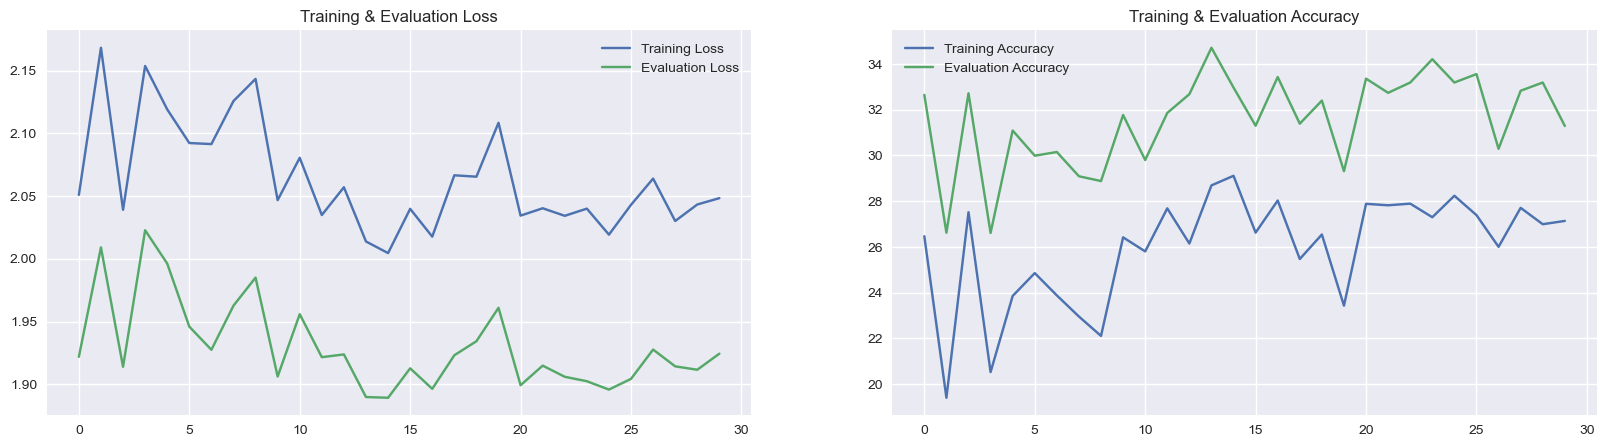

Training Loss Statistics:
 - Minimum: 2.0045469455337526
 - Maximum: 2.1681233002471925
 - Average: 2.063845608305613
 - Final value: 2.0483201554107664

Evaluation Loss Statistics:
 - Minimum: 1.8892799180984496
 - Maximum: 2.022757593727112
 - Average: 1.9300096100870767
 - Final value: 1.9244235141754151

Training Accuracy Statistics:
 - Minimum: 19.4
 - Maximum: 29.11
 - Average: 25.995333333333335
 - Final value: 27.136

Evaluation Accuracy Statistics:
 - Minimum: 26.61
 - Maximum: 34.71
 - Average: 31.575666666666667
 - Final value: 31.29


In [101]:
# (3) Plotting learning curves for training and evaluation loss & accuracy:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(eval_loss_list, label='Evaluation Loss')
plt.title('Training & Evaluation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(eval_accuracy_list, label='Evaluation Accuracy')
plt.title('Training & Evaluation Accuracy')
plt.legend()

plt.show()

# Print key statistics for Training Loss
print("Training Loss Statistics:")
print(" - Minimum:", min(train_loss_list))
print(" - Maximum:", max(train_loss_list))
print(" - Average:", sum(train_loss_list) / len(train_loss_list))
print(" - Final value:", train_loss_list[-1])

# Print key statistics for Evaluation Loss
print("\nEvaluation Loss Statistics:")
print(" - Minimum:", min(eval_loss_list))
print(" - Maximum:", max(eval_loss_list))
print(" - Average:", sum(eval_loss_list) / len(eval_loss_list))
print(" - Final value:", eval_loss_list[-1])

# Print key statistics for Training Accuracy
print("\nTraining Accuracy Statistics:")
print(" - Minimum:", min(train_accuracy_list))
print(" - Maximum:", max(train_accuracy_list))
print(" - Average:", sum(train_accuracy_list) / len(train_accuracy_list))
print(" - Final value:", train_accuracy_list[-1])

# Print key statistics for Evaluation Accuracy
print("\nEvaluation Accuracy Statistics:")
print(" - Minimum:", min(eval_accuracy_list))
print(" - Maximum:", max(eval_accuracy_list))
print(" - Average:", sum(eval_accuracy_list) / len(eval_accuracy_list))
print(" - Final value:", eval_accuracy_list[-1])

In [102]:
# Initialize the number of correct predictions to zero
n_correct = 0

# Disabling gradient computation for evaluation, which can save memory and speed up computations
with torch.no_grad():
    # Create a progress bar for our loop using tqdm to visualize the loop's progress
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    
    # Loop through all batches of images and labels from the evaluation data loader
    for i, (imgs, labels) in progress_bar:
        
        # Move the images and labels tensors to the device (e.g., CPU or GPU) on which computations will be performed
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Flatten the images. The 'start_dim=1' ensures that we don't flatten the batch dimension
        flattened_imgs = imgs.flatten(start_dim=1)
        
        # Get the model's predictions for the current batch of images
        preds = model(flattened_imgs)
        
        # Determine the predicted class for each image by finding the index of the max value in the predictions tensor
        pred_labels = torch.argmax(preds, dim=-1)
        
        # Compare the predicted labels with the true labels to find out how many predictions are correct for this batch
        cur_correct = len(torch.where(pred_labels == labels)[0])
        
        # Update the total number of correct predictions
        n_correct = n_correct + cur_correct

# Calculate the accuracy by dividing the number of correct predictions by the total number of images in the test dataset
accuracy = n_correct / len(test_dataset) * 100

# Print the test accuracy, rounded to two decimal places
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 10/10 [00:01<00:00,  7.74it/s]

Test accuracy: 9.55%


C:\Users\Iresha asif\anaconda3\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


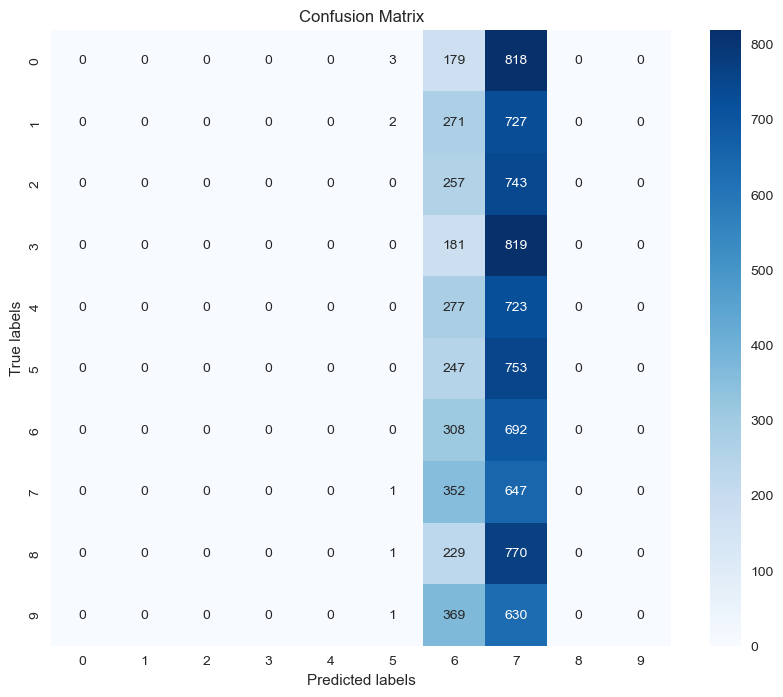

In [103]:
from sklearn.metrics import precision_recall_fscore_support

# (4) Computing the confusion matrix for predictions on the test dataset:
y_true = []
y_pred = []
with torch.no_grad():
    for imgs, labels in eval_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        flattened_imgs = imgs.view(imgs.size(0), -1)
        preds = model(flattened_imgs)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.argmax(1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

# Extracting and printing important information from the confusion matrix
total_predictions = cm.sum()
correct_predictions = cm.diagonal().sum()
accuracy = (correct_predictions / total_predictions) * 100
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

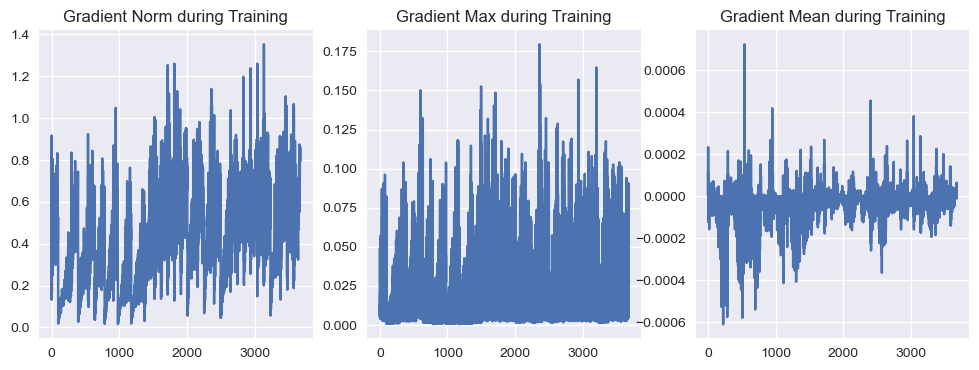

Gradient Norm Statistics:
 - Minimum: 0.0150
 - Maximum: 1.3522
 - Average: 0.4456

Gradient Max Statistics:
 - Minimum: 0.0004
 - Maximum: 0.1795
 - Average: 0.0269

Gradient Mean Statistics:
 - Minimum: -0.0006
 - Maximum: 0.0007
 - Average: -0.0000


In [104]:
# Your original plotting code:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(grad_stats['grad_norm'], label='Gradient Norm')
plt.title('Gradient Norm during Training')
plt.subplot(132)
plt.plot(grad_stats['grad_max'], label='Gradient Max')
plt.title('Gradient Max during Training')
plt.subplot(133)
plt.plot(grad_stats['grad_mean'], label='Gradient Mean')
plt.title('Gradient Mean during Training')
plt.show()

# Added code to print statistics:
print("Gradient Norm Statistics:")
print(f" - Minimum: {min(grad_stats['grad_norm']):.4f}")
print(f" - Maximum: {max(grad_stats['grad_norm']):.4f}")
print(f" - Average: {sum(grad_stats['grad_norm']) / len(grad_stats['grad_norm']):.4f}")

print("\nGradient Max Statistics:")
print(f" - Minimum: {min(grad_stats['grad_max']):.4f}")
print(f" - Maximum: {max(grad_stats['grad_max']):.4f}")
print(f" - Average: {sum(grad_stats['grad_max']) / len(grad_stats['grad_max']):.4f}")

print("\nGradient Mean Statistics:")
print(f" - Minimum: {min(grad_stats['grad_mean']):.4f}")
print(f" - Maximum: {max(grad_stats['grad_mean']):.4f}")
print(f" - Average: {sum(grad_stats['grad_mean']) / len(grad_stats['grad_mean']):.4f}")